In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [3]:
# CONFIG
TRAIN_PATH = "LSTM-Multivariate_pollution.csv"
TEST_PATH = "pollution_test_data1.csv"

TIME_STEPS = 12     # shorter lookback -> faster per epoch
BATCH_SIZE = 128
EPOCHS = 50
PATIENCE = 10
LR = 1e-3

In [4]:
# LOAD & ALIGN COLUMNS
df_train = pd.read_csv(TRAIN_PATH)
df_test = pd.read_csv(TEST_PATH)

df_train

,date,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
0,2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
1,2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2,2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
3,2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
4,2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0
...,...,...,...,...,...,...,...,...,...
43795,2014-12-31 19:00:00,8.0,-23,-2.0,1034.0,NW,231.97,0,0
43796,2014-12-31 20:00:00,10.0,-22,-3.0,1034.0,NW,237.78,0,0
43797,2014-12-31 21:00:00,10.0,-22,-3.0,1034.0,NW,242.70,0,0
43798,2014-12-31 22:00:00,8.0,-22,-4.0,1034.0,NW,246.72,0,0


In [5]:
df_test

,dew,temp,press,wnd_dir,wnd_spd,snow,rain,pollution
0,-16,4,1027,SE,3.58,0,0,128
1,-17,5,1027,SE,7.60,0,0,77
2,-16,4,1027,SE,9.39,0,0,65
3,-16,1,1028,cv,0.89,0,0,79
4,-14,0,1028,NE,1.79,0,0,93
...,...,...,...,...,...,...,...,...
341,-23,-2,1034,NW,231.97,0,0,8
342,-22,-3,1034,NW,237.78,0,0,10
343,-22,-3,1034,NW,242.70,0,0,10
344,-22,-4,1034,NW,246.72,0,0,8


In [6]:
# Drop date column in train set as test set doesnt have it
if "date" in df_train.columns:
          df_train = df_train.drop(columns=["date"])

# Ensure consistent column order
cols = ["pollution", "dew", "temp", "press", "wnd_dir", "wnd_spd", "snow", "rain"]
df_train = df_train[cols]
df_test = df_test[cols]
df_train

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
0,129.0,-16,-4.0,1020.0,SE,1.79,0,0
1,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2,159.0,-11,-5.0,1021.0,SE,3.57,0,0
3,181.0,-7,-5.0,1022.0,SE,5.36,1,0
4,138.0,-7,-5.0,1022.0,SE,6.25,2,0
...,...,...,...,...,...,...,...,...
43795,8.0,-23,-2.0,1034.0,NW,231.97,0,0
43796,10.0,-22,-3.0,1034.0,NW,237.78,0,0
43797,10.0,-22,-3.0,1034.0,NW,242.70,0,0
43798,8.0,-22,-4.0,1034.0,NW,246.72,0,0


In [7]:
df_test

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
0,128,-16,4,1027,SE,3.58,0,0
1,77,-17,5,1027,SE,7.60,0,0
2,65,-16,4,1027,SE,9.39,0,0
3,79,-16,1,1028,cv,0.89,0,0
4,93,-14,0,1028,NE,1.79,0,0
...,...,...,...,...,...,...,...,...
341,8,-23,-2,1034,NW,231.97,0,0
342,10,-22,-3,1034,NW,237.78,0,0
343,10,-22,-3,1034,NW,242.70,0,0
344,8,-22,-4,1034,NW,246.72,0,0


In [8]:
# SIMPLE MISSING VALUE HANDLING
# numeric interpolation +  foward/backward fill for category
num_cols = ["pollution", "dew", "temp", "press", "wnd_spd", "snow", "rain"]
df_train[num_cols] = df_train[num_cols].interpolate(limit_direction="both", axis=0)
df_test[num_cols] = df_test[num_cols].interpolate(limit_direction="both", axis=0)

df_train["wnd_dir"] = df_train["wnd_dir"].ffill().bfill()
df_test["wnd_dir"] = df_test["wnd_dir"].ffill().bfill()

In [9]:
# LEAK_FREE PREPROCESSING (OneHotEncoder for wnd_dir + scaling)
# Built a ColumnTransformer: OneHot for wnd_dir, MinMax for numeric
numeric_features = ["pollution", "dew", "temp", "press", "wnd_spd", "snow", "rain"]
cat_features = ["wnd_dir"]

# Build a ColumnTransformer that will be FIT ONLY on the TRAINING data
# Note: handle_unkown='ignore' prevents errors if test has unseen categories
preprocessor = ColumnTransformer(
          transformers=[
                    ("num", MinMaxScaler(), numeric_features),
                    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_features)
          ], remainder = "drop",
)

# FIT on train Only -> this prevents leakage
preprocessor.fit(df_train)

# TRANSFORM train and test using the SAME fitted preprocessor
X_train_full = preprocessor.transform(df_train).astype(np.float32)
X_test_full = preprocessor.transform(df_test).astype(np.float32)

print ("Processed feature dims (train/test):", X_train_full.shape, X_test_full.shape)

Processed feature dims (train/test): (43800, 11) (346, 11)


In [10]:
# CREATE SEQUENCES (sliding window)

def create_sequences_from_array(X, time_steps):
          """
          X: 2D array (timesteps, features)
          returns: X_seq (samples, time_steps, features), y_next (samples,)
          target is the pollution value at t+time_steps (we assume pollution is index 0 in numeric block)
          """
          xs, ys = [], []
          for i in range(len(X) - time_steps):
                    xs.append(X[i:i+time_steps])
                    # pollution scaled value is at column index 0 because ColumnTransformer place numeric block first
                    ys.append(X[i+time_steps, 0])
          return np.array(xs, dtype=np.float32), np.array(ys, dtype=np.float32)

Xtr_seq, ytr_seq = create_sequences_from_array(X_train_full, TIME_STEPS)
Xte_seq, yte_seq = create_sequences_from_array(X_test_full, TIME_STEPS)

print("Xtr_seq shape:", Xtr_seq.shape, "ytr_seq shape:", ytr_seq.shape)
print("Xte_seq shape:", Xte_seq.shape, "yte_seq shape:", yte_seq.shape)

Xtr_seq shape: (43788, 12, 11) ytr_seq shape: (43788,)
Xte_seq shape: (334, 12, 11) yte_seq shape: (334,)


In [11]:
# tf.data pipeline for speed
def make_tf_dataset(X, y, batch_size, shuffle=True):
          ds = tf.data.Dataset.from_tensor_slices((X, y))
          if shuffle:
                    ds = ds.shuffle(buffer_size=2048, seed=SEED)
          ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
          return ds

train_ds = make_tf_dataset(Xtr_seq, ytr_seq, BATCH_SIZE, shuffle=True)
val_split = 0.1
val_size = int(len(Xtr_seq) * val_split)
if val_size > 0:
          X_val = Xtr_seq[-val_size:]
          y_val = ytr_seq[-val_size:]
          X_tr = Xtr_seq[:-val_size]
          y_tr = ytr_seq[:-val_size]
          train_ds = make_tf_dataset(X_tr, y_tr, BATCH_SIZE, shuffle=True)
          val_ds = make_tf_dataset(X_val, y_val, BATCH_SIZE, shuffle=False)
else:
          val_ds = None

In [22]:
# MODEL
n_features = Xtr_seq.shape[2]

tf.keras.backend.clear_session()
inputs = tf.keras.Input(shape=(TIME_STEPS, n_features))
x = tf.keras.layers.Conv1D(filters=64, kernel_size=3, padding="causal", activation="relu")(inputs)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.LSTM(64, return_sequences=False)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(32, activation="relu")(x)
outputs = tf.keras.layers.Dense(1)(x)

model = tf.keras.Model(inputs, outputs)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
              loss=tf.keras.losses.Huber(),
              metrics=["mae"])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 12, 11)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 12, 64)         │         2,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 12, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,825 (147.75 KB)

 Trainable params: 37,569 (146.75 KB)

 Non-trainable params: 256 (1.00 KB)

In [23]:
# CALLBACKS
callbacks = [
          tf.keras.callbacks.EarlyStopping(
                    monitor = "val_loss",
                    patience=PATIENCE,
                    restore_best_weights=True
          ),
          tf.keras.callbacks.ReduceLROnPlateau(
                    monitor="val_loss",
                    factor=0.5,
                    patience=5,
                    verbose=1
          )
]

# TRAIN
if val_ds is not None:
          history = model.fit(train_ds, validation_data=val_ds,
                              epochs=EPOCHS, callbacks=callbacks,
                              verbose=2)
else:
          history = model.fit(
                    train_ds,
                    epochs=EPOCHS,
                    callbacks=callbacks,
                    verbose=2
          )

Epoch 1/50
308/308 - 4s - 13ms/step - loss: 0.0304 - mae: 0.1709 - val_loss: 0.0024 - val_mae: 0.0522 - learning_rate: 0.0010
Epoch 2/50
308/308 - 2s - 6ms/step - loss: 0.0040 - mae: 0.0670 - val_loss: 0.0013 - val_mae: 0.0353 - learning_rate: 0.0010
Epoch 3/50
308/308 - 2s - 7ms/step - loss: 0.0022 - mae: 0.0482 - val_loss: 9.8262e-04 - val_mae: 0.0301 - learning_rate: 0.0010
Epoch 4/50
308/308 - 2s - 7ms/step - loss: 0.0017 - mae: 0.0418 - val_loss: 9.5959e-04 - val_mae: 0.0294 - learning_rate: 0.0010
Epoch 5/50
308/308 - 2s - 6ms/step - loss: 0.0015 - mae: 0.0384 - val_loss: 7.8918e-04 - val_mae: 0.0266 - learning_rate: 0.0010
Epoch 6/50
308/308 - 2s - 6ms/step - loss: 0.0013 - mae: 0.0362 - val_loss: 8.6143e-04 - val_mae: 0.0281 - learning_rate: 0.0010
Epoch 7/50
308/308 - 2s - 7ms/step - loss: 0.0012 - mae: 0.0343 - val_loss: 8.0315e-04 - val_mae: 0.0288 - learning_rate: 0.0010
Epoch 8/50
308/308 - 2s - 7ms/step - loss: 0.0011 - mae: 0.0319 - val_loss: 6.7964e-04 - val_mae: 0.0281

In [24]:
# PREDICT ON TEST
y_pred_scaled = model.predict(Xte_seq, batch_size=BATCH_SIZE).flatten()
y_true_scaled = yte_seq.flatten()

# To inverse scale we access the numeric scaler inside the ColumnTransformer
num_scaler = preprocessor.named_transformers_["num"]

pollution_min = num_scaler.data_min_[0]
pollution_max = num_scaler.data_max_[0]
pollution_range = pollution_max - pollution_min

y_pred = y_pred_scaled * pollution_range + pollution_min
y_true = y_true_scaled * pollution_range + pollution_min

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


In [25]:
# METRICS
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
try:
          r2 = r2_score(y_true, y_pred)
except:
          r2 = float("nan")
          
          
print("\nEVALUATION on TEST SEQUENCES")
print(f"MAE:  {mae:.4f}")
print(f"MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R2:   {r2:.4f}")


EVALUATION on TEST SEQUENCES
MAE:  15.3179
MSE:  748.5261
RMSE: 27.3592
R2:   0.9233


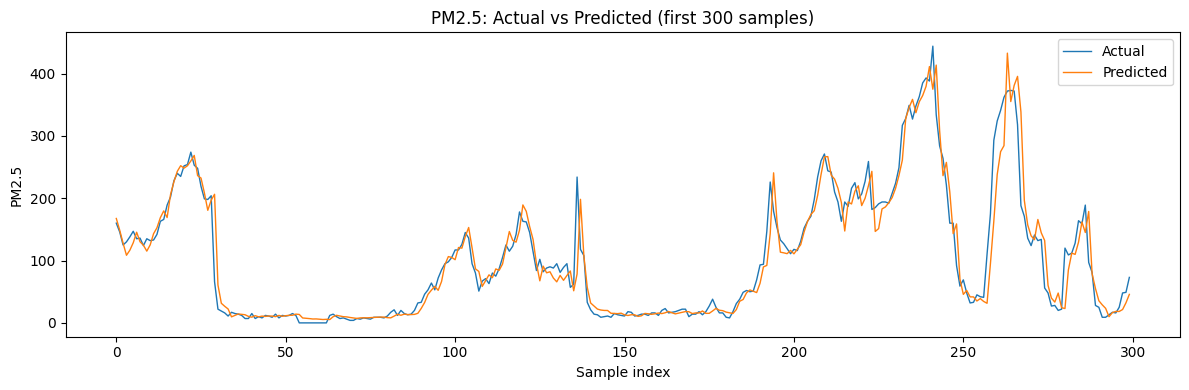

In [26]:
# PLOTS
N = min(300, len(y_true))
plt.figure(figsize=(12,4))
plt.plot(y_true[:N], label="Actual", linewidth=1)
plt.plot(y_pred[:N], label="Predicted", linewidth=1)
plt.title("PM2.5: Actual vs Predicted (first {} samples)".format(N))
plt.xlabel("Sample index")
plt.ylabel("PM2.5")
plt.legend()
plt.tight_layout()
plt.show()

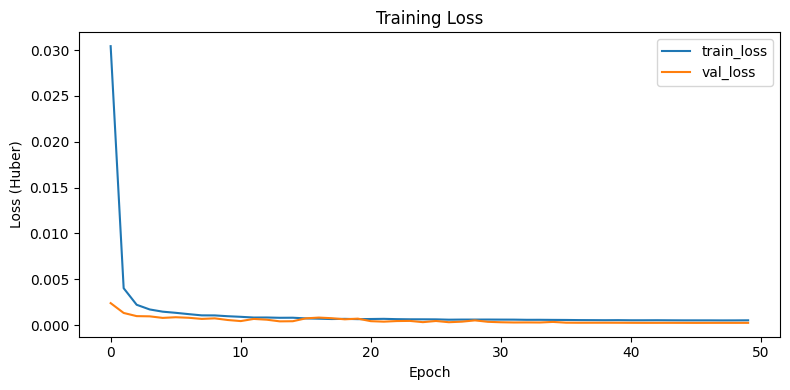

In [27]:
plt.figure(figsize=(8,4))
plt.plot(history.history["loss"], label="train_loss")
if "val_loss" in history.history:
    plt.plot(history.history["val_loss"], label="val_loss")
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss (Huber)")
plt.legend()
plt.tight_layout()
plt.show()